In [1]:
import numpy as np
import scipy.signal, scipy.io
import matplotlib.pyplot as plt

In [2]:
FS = 51200

def load_mat(filename):
    mat = scipy.io.loadmat(filename, simplify_cells=True)
    data = mat["Final"]
    return data

# structure:
# Final.Data = Data; # contient "Time" qui est la même chose que Final.time
# Final.marteau.fen = signal_marteau_fen;
# Final.accelero.fen = signal_accelero_fen;
# Final.marteau.brut = signal_marteau;
# Final.accelero.brut = signal_accelero;
# Final.FRF = FRF(1:Nfft/2);
# Final.freq = freq;
# Final.time = time;

def plot_data(data, title, fmax):
    fig, axs = plt.subplots(4)
    fig.set_size_inches(10,10)
    fig.suptitle(title)

    def plot_response(ax, name, data, marge, epsilon):
        x = data[name]["fen"]
        ax.set_title(name)

        start = np.min((np.abs(x) > epsilon).nonzero()) - int(marge*FS)
        end = np.max((np.abs(x) > epsilon).nonzero()) + int(marge*FS)

        ax.plot(data["time"][start:end], data[name]["fen"][start:end])

    plot_response(axs[0], "marteau", data, 0.001, 0.05)
    plot_response(axs[1], "accelero", data, 0.001, 1)

    domaine = data["freq"] < fmax
    axs[2].set_title("FRF (dB)")
    axs[2].plot(data["freq"][domaine], 20*np.log(np.abs(data["FRF"][domaine])))
    axs[3].set_title("Phase (rad)")
    axs[3].plot(data["freq"][domaine], np.angle(data["FRF"][domaine]))
    return fig, axs

(<Figure size 1000x1000 with 4 Axes>,
 array([<Axes: title={'center': 'marteau'}>,
        <Axes: title={'center': 'accelero'}>,
        <Axes: title={'center': 'FRF (dB)'}>,
        <Axes: title={'center': 'Phase (rad)'}>], dtype=object))

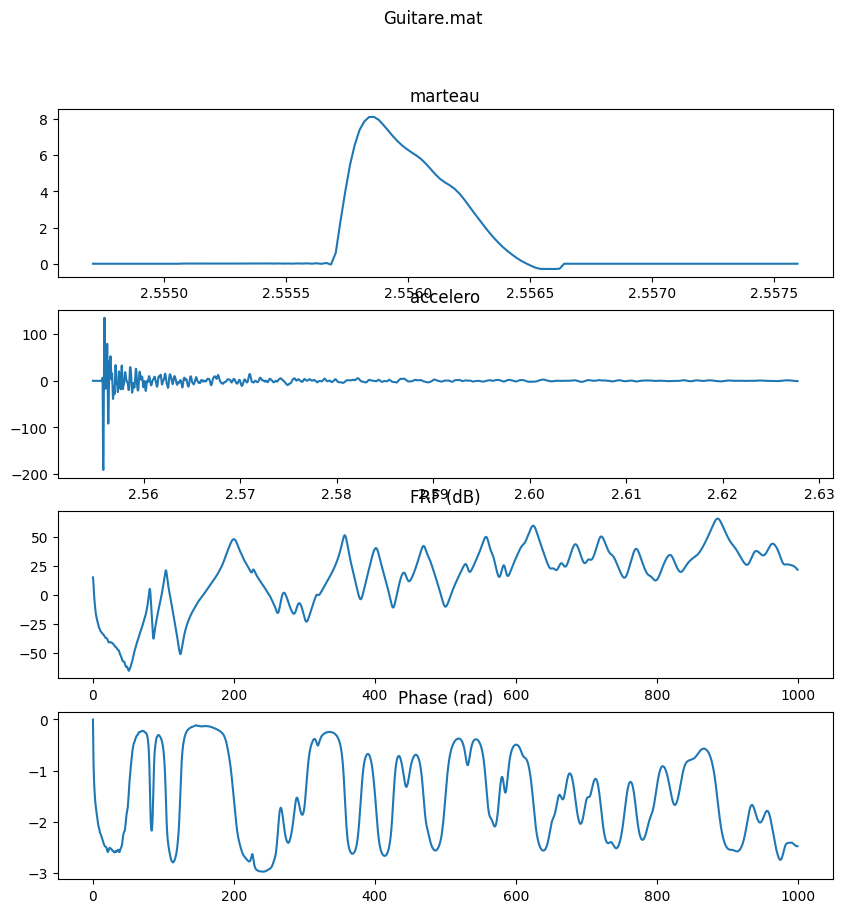

In [3]:
filename = "Guitare.mat"
data = load_mat(filename)
plot_data(data, filename, 1000)

In [4]:
fmax = 600
domaine = data["freq"] < fmax

freq = data["freq"][domaine]
frf = data["FRF"][domaine]
phase = np.angle(data["FRF"][domaine])
mag = 20 * np.log(abs(data["FRF"][domaine]))

def trouver_pics(freq, mag, phase,plot=False):
    i_pisur2 = np.where(np.diff(np.sign(phase + np.pi/2)))[0]
    if plot:
        plt.plot(freq, mag)
        plt.plot(freq[i_pisur2], mag[i_pisur2], 'x')
        plt.show()
    return i_pisur2

def get_delta_f(f, f_zone, plot=False):
    domaine = np.abs(freq-f) < f_zone

    i_max = np.argmax(mag[domaine])
    f_max = freq[domaine][i_max]
    mag_max = mag[domaine][i_max]

    i_zone = np.where(np.diff(np.sign(mag[domaine] - mag_max +3)))[0]
    if len(i_zone) != 2:
        print("oh no")
        return
    i_moins, i_plus = i_zone
    i_plus += 1
    f_moins, f_plus = freq[domaine][i_moins], freq[domaine][i_plus]
    mag_moins, mag_plus = mag[domaine][i_moins], mag[domaine][i_plus]
    delta_f = f_plus - f_moins
    if plot:
        plt.plot(freq[domaine], mag[domaine])
        plt.plot(f_max, mag_max, 'x')
        plt.plot([f_moins, f_plus], [mag_moins, mag_plus])
        plt.show()
    print(f"f_max={f_max:.2} Hz, mag_max={mag_max:.2} dB, delta f (-3db) = {delta_f:.2} Hz")
    return delta_f

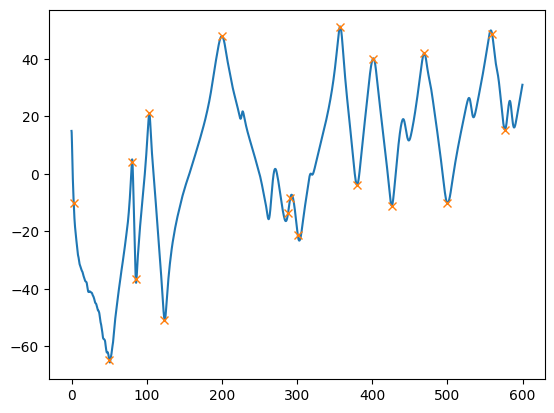

In [5]:
i_pics = trouver_pics(freq, mag, phase, plot=True)

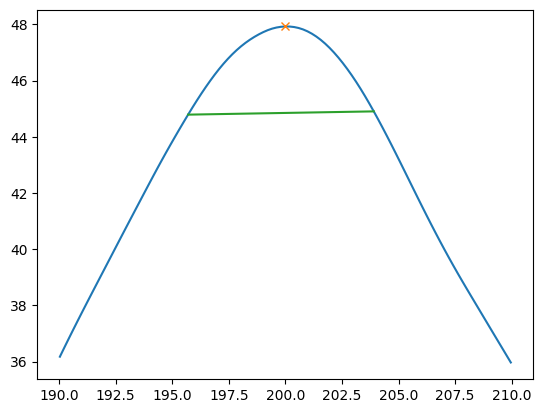

f_max=2e+02 Hz, mag_max=4.8e+01 dB, delta f (-3db) = 8.2 Hz


8.203125

In [6]:
get_delta_f(200, 10, True)

In [48]:
def trouver_pics(freq, mag, phase,color="blue",plot=False):
    i_pisur2 = np.where(np.diff(np.sign(phase + np.pi/2)))[0]
    if plot:
        #plt.plot(freq, mag)
        plt.plot(freq[i_pisur2], mag[i_pisur2], 'x',color=color)
    return i_pisur2

In [37]:
def file2text(file):
    filesplit = file.split("_")[:-1]
    return ' '.join(filesplit).capitalize()

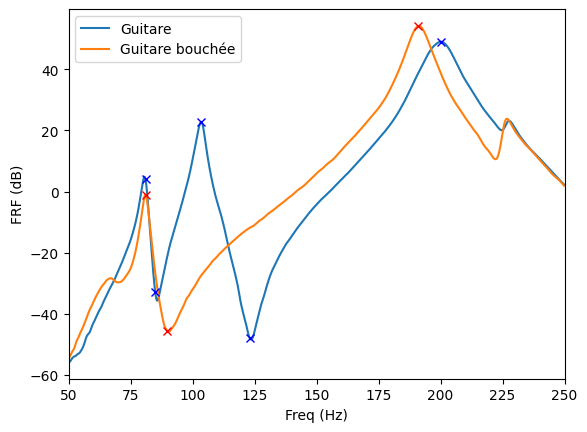

Pics de la Guitare:[ 81.0546875  84.9609375 103.515625  123.046875  200.       ]
Pics de la Guitare bouchée:[ 81.0546875  89.84375   191.015625 ]


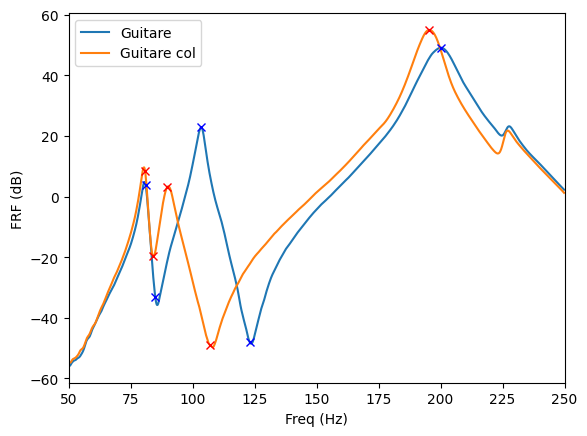

Pics de la Guitare:[ 81.0546875  84.9609375 103.515625  123.046875  200.       ]
Pics de la Guitare col:[ 80.859375  83.984375  89.84375  107.03125  195.3125  ]


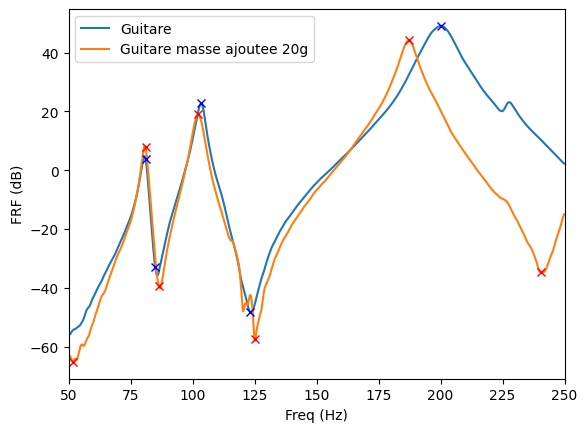

Pics de la Guitare:[ 81.0546875  84.9609375 103.515625  123.046875  200.       ]
Pics de la Guitare masse ajoutee 20g:[ 51.7578125  81.0546875  86.328125  102.1484375 125.        187.109375
 240.625    ]


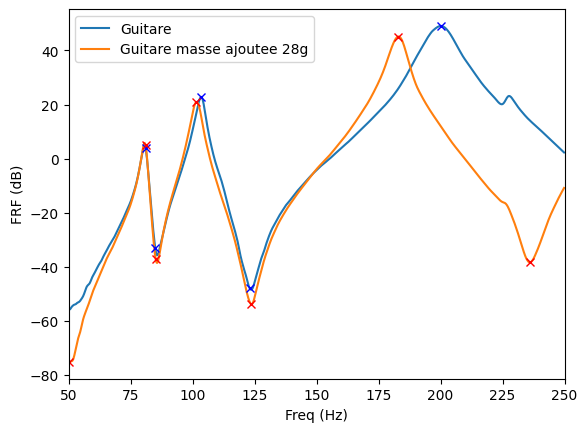

Pics de la Guitare:[ 81.0546875  84.9609375 103.515625  123.046875  200.       ]
Pics de la Guitare masse ajoutee 28g:[ 50.1953125  81.0546875  85.15625   101.5625    123.4375    182.8125
 235.9375   ]


(array([ 81.0546875,  84.9609375, 103.515625 , 123.046875 , 200.       ]),
 array([ 50.1953125,  81.0546875,  85.15625  , 101.5625   , 123.4375   ,
        182.8125   , 235.9375   ]))

In [51]:
def compare(file1,file2):
    data1 = load_mat(file1)
    data2 = load_mat(file2)

    freqmin = 50
    freqmax = 250

    domaine = np.logical_and(data["freq"] < freqmax ,data["freq"] > freqmin )

    freq1 = data1["freq"][domaine]
    mag1 = 20*np.log(np.abs(data1["FRF"]))[domaine]
    phase1 = np.angle(data1["FRF"])[domaine]
    
    freq2 = data2 ["freq"][domaine]
    mag2 = 20*np.log(np.abs(data2["FRF"]))[domaine]
    phase2 = np.angle(data2["FRF"])[domaine]

    plt.figure()
    plt.xlim([freqmin,freqmax])

    plt.plot(freq1,mag1,label = file2text(file1))
    plt.plot(freq2,mag2,label = file2text(file2))
    
    pics1 = trouver_pics(freq1,mag1,phase1,color="blue",plot=True)
    pics2 = trouver_pics(freq2,mag2,phase2,color="red",plot=True)

    plt.xlabel("Freq (Hz)")
    plt.ylabel("FRF (dB)")
    plt.legend()
    plt.show()

    print(f"Pics de la {file2text(file1)}:{freq1[pics1]}\nPics de la {file2text(file2)}:{freq2[pics2]}")
    return freq1[pics1],freq2[pics2]

compare("Guitare_2.mat","Guitare_bouchée_2.mat")
compare("Guitare_2.mat","Guitare_col_2.mat")
compare("Guitare_2.mat","Guitare_masse_ajoutee_20g_2.mat")
compare("Guitare_2.mat","Guitare_masse_ajoutee_28g_3.mat")